# Recommendation Systems using Deep Autoencoders

In this lab, you'll learn how to generate recommendations for users based on ratings they've provided for other items. 

### Getting started

First, let's check what GPUs we have on our system:

In [1]:
!nvidia-smi

Fri Feb 16 21:21:02 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 387.26                 Driver Version: 387.26                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla M40           On   | 00000000:04:00.0 Off |                    0 |
|  0%   23C    P8    19W / 250W |     11MiB / 11443MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

We see our system has 1 GPU, a V100 with a PCIE link.

Additionally, let's examine our file system:

In [2]:
!ls -al

total 85740
drwxr-xr-x 16 34021 1001     4096 Feb 16 21:19 .
drwxr-xr-x 13 34021 1001     4096 Feb 14 19:01 ..
-rw-r--r--  1 34021 1001     8196 Jan 26 17:50 .DS_Store
drwxr-xr-x  7 34021 1001     4096 Feb 16 21:18 .git
-rw-r--r--  1 34021 1001      150 Feb 15 21:20 .gitignore
drwxr-xr-x  4 34021 1001     4096 Jan 26 18:51 .idea
drwxr-xr-x  2 34021 1001     4096 Feb 15 21:34 .ipynb_checkpoints
-rw-r--r--  1 34021 1001   101983 Feb 16 21:18 Answers.ipynb
-rw-r--r--  1 34021 1001    42136 Feb 16 21:18 DLI Lab - Stretch.ipynb
-rw-r--r--  1 34021 1001    46803 Feb 16 21:19 DLI Lab.ipynb
-rw-r--r--  1 34021 1001      528 Jan 26 17:50 Dockerfile
-rw-r--r--  1 34021 1001     1075 Jan 26 17:50 LICENSE
drwxr-xr-x 14 34021 1001     4096 Feb  2 16:01 Netflix
-rw-r--r--  1 34021 1001 44496853 Feb  8 15:46 Online Retail.csv
-rw-r--r--  1 34021 1001     3428 Jan 26 17:50 README.md
drwxr-xr-x  2 34021 1001     4096 Feb  2 15:59 __pycache__
drwxr-xr-x  4 34021 1001     4096 Jan 26 18:51 azkaban
-rw-r-

We see several folders, Jupyter notebooks, and Python scripts. We'll visit each of these later in the lab.

### Applications and Use Cases

The digital space is an important place for businesses to interact with their customers. In such a vast space and with today's wealth of information, customers are increasingly looking to businesses to help provide guidance on what choices they should make. Recommendation systems are able to provide this guidance; they are systems that help predict the “rating” or “preference” based on the rating provided by users of an item. They’ve become very popular in recent years, and are used in many areas such as:

* **Media and Entertainment** - movies, music, news, and videos, 
* **Retail** - clothes, books, and other products, 
* **Social Media** - friends, celebrities to follow, groups, restaurants, and ads. 

There are several ways to implement recommender systems, the most common of which is the Collaborative Filtering approach. This approach examines the ratings users have given items, and leverages the groups collaborative ratings to predict missing ratings. Consider the following example: A user named John has rated Die Hard as 5 stars and Die Hard 2 as 4 stars. Another user named Matt has rated Die Hard as 5 stars but has not rated Die Hard 2. Using the information we know about John's ratings for Die Hard and Die Hard 2, we might infer that Matt would rate Die Hard 2 as 4 stars as well. This example is obviously very simple but it demonstrates the essence of collaborative filtering approaches; we are able to use many users' ratings of items to infer missing ratings.

Another approach to recommender systems is to use users' ratings of items in a collaborative fashion as well as information about the users or items. For example, if John rated several movies in the Romantic Comedy genre postively such as The Proposal or When Harry Met Sally, we might recommend the movie Pretty Women. These approaches are known as Content-based recommender systems, and can leverage a wide variety of rich data sources such as transactional data, user and item attributes and sub-attributes, and user-item ratings.

Lastly, another common approach, Knowledge-based recommender systems, applies to items that are purchased on an infrequent basis. For example, an individual might purchase a computer every couple of years. With these approaches, the users specifies requirements and preferences, and that specification is combined with domain knowledge to generate recommendations. 

In this lab, we will focus on collaborative filtering approaches.

### Collaborative Filtering Apporaches

Collaborative Filtering approaches can be classified into two types of methods:

* **Memory-based methods**: These methods approach the problem by identifying a target customer Jane and identifying customers who are most similar to Jane. We can take these similar customers and combine their ratings for various items, and use those ratings to infer which items to recommend for Jane. Examples of these methods are nearest neighbor approaches using Pearson's correlation or cosine distance, or k-nearest neighbors approaches. Memory-based methods tend to be more heuristical, and therefore, their results can sometimes be easy to interpret. However, as your dataset grows in size, these memory based approaches may not be able use all the information available (imagine k-nearest neighbors with a large k), and often work poorly with sparse datasets with a large cardinality of items due to the curse of dimensionality.
* **Model-based methods**: The methods approach the problem by specifying a set of inputs (often the users-items ratings matrix) and specifying an output (often the missing or unobserved ratings for a particular user) and work to identify a mapping from the inputs to the outputs. These methods often follow data mining and machine learning paradigms by parameterizing the mapping and use some optimization technique to minimize the error and identify the best parameters for that mapping. Examples of these approaches may be descision trees, Bayesian methods, or the deep autoencoders we will use in this lab.

In general, collaborative filtering approach can be impeded by two challenges:

* **Scalability**: Training may occur on millions of users and hundreds of thousands of items (or more!). Designing an algorithm that can be trained using this large amount of data and provide low-latency inference in a production system is key to a successful recommendation engine. 
* **Sparsity**: There may be hundreds of thousands of items, and users can only rate so many items. Resultingly, the data for users may be very sparse, and this consideration must be kept in mind when selecting the appropriate algorithm.

This lab proposes using Deep Autoencoders to do Collaborative Filtering. We also propose a new training algorithm based on iterative ouput re-feeding to overcome naural sparseness of collaborate filtering. This new algorithm significally speeds up training and improves model performance, outperforming previous state-of-the art models on a time split Netflix data set.

## Introduction to Autoencoders

Autoencoders are neural networks that are trained to attempt to copy its input to its output. Essentially, an autoencoder is attempting to approximate the identity function $f(x) = x$ such that the error between $f(x)$ and $x$ is minimized, under some constraints. These constraints are usually that the hidden layers, or latent space, are lower dimensional than the inputs. An autoencoder whose code dimension is less than the input dimension is called undercomplete. This constraint prevents the autoencoder from merely memorizing the data, and forces the autoencoder to learn efficient representations of the data, called "codings", that contain the patterns and features of the data. 

An autoencoder is composed of two parts; an encoder, and a decoder. The encoder maps the data to the hidden layer, or codings, and the decoder maps the codings back to the inputs. 

Autoencoders are an excellent tool for dimensionality reduction and can be thought of as a strict generalization of principle component analysis (PCA). An autoencoder without non-linear activations and only with “code” layer should be able to learn PCA transformation in the encoder if trained to optimize mean squared error (MSE) loss.

![AutoEncoder](images/AutoEncoder.png)

### MNIST example

Autoencoders are fairly easy to implement. Below we show an implementation using the popular TensorFlow framework:

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Epoch: 0 Test MSE: 0.025010614
Epoch: 1 Test MSE: 0.023048468
Epoch: 2 Test MSE: 0.0218137
Epoch: 3 Test MSE: 0.021268478
Epoch: 4 Test MSE: 0.021533297
Epoch: 5 Test MSE: 0.021676585
Epoch: 6 Test MSE: 0.021387115
Epoch: 7 Test MSE: 0.021400116
Epoch: 8 Test MSE: 0.021368964
Epoch: 9 Test MSE: 0.020758744


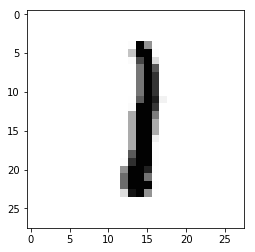

Original Image


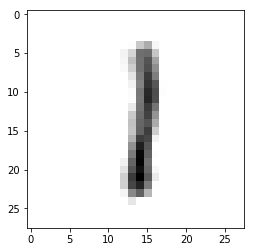

Reconstructed Image


In [3]:
from __future__ import division, print_function, unicode_literals
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from tensorflow.examples.tutorials.mnist import input_data


# matplotlib settings
%matplotlib inline

# load data
mnist = input_data.read_data_sets("/tmp/data/")

# network settings
n_inputs = 28 * 28
n_hidden1 = 128
n_hidden2 = 64
n_hidden3 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.01

# define placeholder
X_placeholder = tf.placeholder(tf.float32, shape=[None, n_inputs])

# define graph
hidden1 = fully_connected(X_placeholder, n_hidden1)
hidden2 = fully_connected(hidden1, n_hidden2)
hidden3 = fully_connected(hidden2, n_hidden3)
outputs = fully_connected(hidden3, n_outputs)
loss = tf.reduce_mean(tf.square(outputs - X_placeholder))
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

# create a node to initialize our global variables
init = tf.global_variables_initializer()

# training settings
n_epochs = 10
batch_size = 100
n_batches = mnist.train.num_examples // batch_size
X_test = mnist.test.images

# execute graph
with tf.Session() as sess:
    init.run()
    for n_epoch in range(n_epochs):
        for n_batch in range(n_batches):
            X_batch, _ = mnist.train.next_batch(batch_size)
            sess.run(train_op, feed_dict={X_placeholder: X_batch})
        loss_eval = loss.eval(feed_dict={X_placeholder: X_test})
        print('Epoch:', n_epoch, 'Test MSE:', loss_eval)
    
    # show random test example
    X_test, _ = mnist.test.next_batch(1)
    fig1 = plt.figure()
    plt.imshow(X_test.reshape((28, 28)), cmap="Greys", interpolation="nearest")
    plt.show()
    print('Original Image')
    fig2 = plt.figure()
    X_test_eval = sess.run(outputs, feed_dict={X_placeholder: X_test})
    plt.imshow(X_test_eval.reshape((28, 28)), cmap="Greys", interpolation="nearest")
    plt.show()
    print('Reconstructed Image')

Other forms of autoencoders exist and are described below:

* **Constrained Autoencoder** - Autoencoders implement an encoding layer mapping the input to a codings layer, and a decoding layer mapping the docings back to the inputs. If the decoder architecture mirrors the encoder architecture, then one can constrain decoder’s weights to be equal to the transposed encoder weights for each mirrored layer. Such an autoencoder is called constrained or tied and has almost two times less free parameters than unconstrained one.
* **Denoising Autoencoder** - Autoencoders can be used to remove noise from images. Typically, this is done by taking the input and adding a little bit of random noise to it; this noisy input is passed into the model while keeping the output noise-free. The autoencoder learns to map the noisy images to the noise-free images, and essentially learns how to remove noise from an image. 
* **Sparse Autoencoder** - Sparse autoencoders are autoencoders whose loss function is a combination of the reconstruction loss and some sparsity loss. By imposing this sparsity loss, we regularize the autoencoder and force it to learn more robust features of the data. Typically, sparse autoencoders are utilized as a means for learning the latent space of data; this latent space is later used as the input in another task such as regression or classification. 
* **Variational Autoencoder** - Variational autoencoders are a twist on traditional autoencoders. Instead of learning a deterministic codings layer, variational autoencoders learn a stochastic codings layer. This layer often comes in the form of a multivariate Gaussian distribution, where the means and sigma are learned from the data. This twist allows our model to take a generative flavor; by passing random Gaussian noise into the codings layer, we can generate entirely new images that look realisitc. For an example application of this concept, check out a variational autoencoder applied to celebrity faces: http://research.nvidia.com/publication/2017-10_Progressive-Growing-of 

### Exercises

1) Implement a constrained autoencoder for the MNIST dataset. 

Hint: it may be easier to implement the weights and biases by hand instead of using TensorFlow's default `fully_connected` layer.

2) Implement a denoising autoencoder for the MNIST dataset. 

Hint: think about how to modify your graph so as to accomodate noisy inputs.

3) Implement a sparse autoencoder for the MNIST dataset. 

4) Implement a variational autoencoder for the MNIST dataset. Can you sample from the codings to generate new images of digits?

5) Autoencoders learn a set of codings that represent the data i.e. it attempts to learn the underlying probability distribution generating the data. What happens if we introduce data from a new probability distribution? For example, what happens if instead of a digit between 0 and 9, we introduce the letter A? Or random noise? Choose one of your previous implementations of an autoencoder and pass in an image from another dataset. What does the reconstruction loss tell us? How can we use this concept to detect anomalies in our data?

## Experiment and results

### Dataset description

The Netflix dataset is a well known and historically significant dataset, as its publication and prize from the resulting contest motivated a large body of work on recommendation systems. First published in October 2, 2006, the contest ran until September 21, 2009, when a reward of $1,000,000 was rewarded to team "BellKor’s Pragmatic Chaos". More information on their winning model can be found here: https://netflixprize.com/community/topic_1537.html

This dataset contains users, items, and ratings that users gave to the items. The goal is to predict the "missing" or "unobserved" ratings in a separate test dataset. More information about the contest and the dataset can be found here:

https://netflixprize.com/

The raw datasets can be downloaded here (note these have already been downloaded and processed for you to save time):

http://academictorrents.com/details/9b13183dc4d60676b773c9e2cd6de5e5542cee9a

For the ratings prediction task, it is often most relevant to predict future ratings given the past ones instead of predicting ratings missing at random. For evaluation purposes we split the original Netflix Prize training set into several training and testing intervals based on time. Training interval contains ratings which came in earlier than the ones from testing interval.

The testing interval is then randomly split into Test and Validation subsets so that each rating from testing interval has a 50% chance of appearing in either subset. Users and items that do not appear in the training set are removed from both test and validation subsets.

The data has already been downloaded and pre-processed for you. Below is more information on the number of ratings, users, and items in the train and test splits for each time period.


| Dataset  | Netflix 3 months | Netflix 6 months | Netflix 1 year | Netflix full |
| -------- | ---------------- | ---------------- | ----------- |  ------------ |
| Ratings train | 13,675,402 | 29,179,009 | 41,451,832 | 98,074,901 |
| Users train | 311,315 |390,795  | 345,855 | 477,412 |
| Items train | 17,736 |17,757  | 16,907 | 17,768 |
| Time range train | 2005-09-01 to 2005-11-31 | 2005-06-01 to 2005-11-31 | 2004-06-01 to 2005-05-31 | 1999-12-01 to 2005-11-31
| -------- | ---------------- | ----------- |  ------------ |
| Ratings test | 2,082,559 | 2,175,535  | 3,888,684| 2,250,481 |
| Users test | 160,906 | 169,541  | 197,951| 173,482 |
| Items test | 17,261 | 17,290  | 16,506| 17,305 |
| Time range test | 2005-12-01 to 2005-12-31 | 2005-12-01 to 2005-12-31 | 2005-06-01 to 2005-06-31 | 2005-12-01 to 2005-12-31

Let's examine the data. We'll use the `head` Linux command to inspect the first several rows of our train and test dataset from the Netflix 3 Months time split. The first column on the left hand side represents our User IDs; the second column represents our Item IDs; and the third and final column represents the rating that user gave to that time, on an ordinal scale of 1-5.

In [4]:
!head Netflix/N3M_TRAIN/n3m.train.txt

0	4053	3.0
0	2764	4.0
0	3524	4.0
0	5639	4.0
0	12319	3.0
0	12369	4.0
0	14832	4.0
0	22	4.0
0	952	5.0
0	1030	3.0


In [5]:
!head Netflix/N3M_TEST/n3m.test.txt

0	1875	3.0
0	14274	5.0
0	5583	4.0
2	16411	2.0
3	7149	3.0
4	5085	3.0
6	383	3.0
6	4640	5.0
7	81	3.0
7	849	3.0


### Model

The first application of autoencoders to collaborative filtering appeared in "AutoRec: Autoencoders Meet Collaborative Filtering in 2015". The idea is that we have $m$ users and $n$ items, and a matrix $R$ of shape $m$ x $n$ populated with ratings. The rating $r_{ij}$ details the rating given by the *ith* user to the *jth* item. The goal is to infer the missing entries in $R$. The ratings matrix is fed row-by-row into the autoencoder and the reconstruction loss calculated. For more information on U-AutoRec, please see the original paper: http://users.cecs.anu.edu.au/~akmenon/papers/autorec/autorec-paper.pdf

Our model is inspired by the U-AutoRec approach with several important distinctions. We train much deeper models, and do not use any layer-wise pre-training. We are able to do so successfully because we: 

1. use “scaled exponential linear units” (SELUs), 
2. use high dropout rates, and 
3. use iterative output re-feeding during training. 

For most of our experiments we use a batch size of 128, trained using SGD with momentum of 0.9 and learning rate of 0.001, and used Xavier initialization to initialize the parameters. 

In our model, both the encoder and decoder parts of the autoencoder consist of feed-forward neural networks with classical fully connected layers computing $l = f (W ∗ x + b)$, where $f$ is some non-linear activation function. If the range of the activation function is smaller than that of data, the last layer of the decoder should be kept linear. We find it to be very important for the activation function in the hidden layers to contain non-zero negative part, motivating the use SELU units in most of our experiments.

For more information, please see the original paper here: https://arxiv.org/pdf/1708.01715.pdf

For the actual code, please see the codebase here: https://github.com/NVIDIA/DeepRecommender

### Loss function

Since it doesn’t make sense to predict zeros in user’s representation vector $x$, we instead optimize Masked Mean Squared Error loss:

\begin{equation*}
MMSE   = \frac{m_i * (r_i - y_i)^2}{\sum_{i=1}^{n} m_i}
\end{equation*}

where:

* $r_i$ is actual rating, 
* $y_i$ is reconstructed, or predicted rating, 
* $m_i$ is a mask function such that $m_i = 1$ if $r_i \neq 0$, else $m_i = 0$.

Note that there is a straightforward relation between RMSE score and MMSE score: $RMSE = \sqrt{MMSE}$.

### Dense re-feeding

During training and inference, an input $x ∈ R^n$ is very sparse because no user can realistically rate all items (especially if the cardinality of items is very large). On the other hand, the autoencoder’s output $f(x)$ is dense. 

Consider an idealized scenario with a *perfect* $f$, where by perfect $f$ we mean that $f(x)_i$ accurately predicts all user’s future ratings for items $i : x_i = 0$. Additionally, consider the situation where a user has rated all items and $x$ is dense; i.e. $\forall i, x_i \neq 0$. In this idealized scenario, $f(x)_i = x_i, ∀ i : x_i$. 

This means that that if a user rates a new item k (thereby creating a new vector $x^\prime$) then $f(x^\prime)_k = x^\prime_k$ and $f(x^\prime) = f(x^\prime)$. Hence, in this idealized scenario, $y = f(x)$ should be a fixed point of a well trained autoencoder: $f(y) = y$. 

To explicitly enforce the fixed-point constraint and to be able to perform dense training updates, we augment every optimization iteration with an iterative dense re-feeding steps (3 and 4 below) as follows:

1. Given a sparse input $x$, compute dense $f(x)$ and the loss detailed above (forward pass)
2. Compute gradients and perform weight update (backward pass)
3. Treat $f(x)$ as a new example and compute $f(f(x))$. Now both $f(x)$ and $f(f(x))$ are dense and the loss function detailed above has all m as non-zeros. (second forward pass)
4. Compute gradients and perform weight update (second backward pass)

Steps 3 and 4 can also be performed more than once for every iteration.

### Training

To train our autoencoder on our data, we'll use the `run.py` script located in our current working directory. We can pass arguments to this script specifying the path to the location of the training and test data, the architecture of our model, and general settings for logging. To run this script in this Jupyter notebook, we can use the command `!python run.py <insert parameters here>`. Execute the cell below to train our autoencoder with 3 hidden layers of 128, 128, and a final codings layer of 256 on the Netflix 3 Month dataset for 3 epochs. Note that training this model may take up to 10 minutes depending on our hardware setup.

In [6]:
import time

In [7]:
start = time.time()
!python run.py --gpu_ids 0 \
--path_to_train_data Netflix/N3M_TRAIN \
--path_to_eval_data Netflix/N3M_TEST \
--hidden_layers 128,128,256 \
--non_linearity_type selu \
--batch_size 128 \
--logdir model_save \
--drop_prob 0.8 \
--optimizer momentum \
--lr 0.005 \
--weight_decay 0 \
--aug_step 1 \
--noise_prob 0 \
--num_epochs 3 \
--summary_frequency 500
end = time.time()
print(int(end - start), 'seconds')

Namespace(aug_step=1, batch_size=128, constrained=False, drop_prob=0.8, gpu_ids='0', hidden_layers='128,128,256', logdir='model_save', lr=0.005, noise_prob=0.0, non_linearity_type='selu', num_epochs=3, optimizer='momentum', path_to_eval_data='Netflix/N3M_TEST', path_to_train_data='Netflix/N3M_TRAIN', skip_last_layer_nl=False, summary_frequency=500, weight_decay=0.0)
Loading training data
Data loaded
Total items found: 311315
Vector dim: 17736
Loading eval data
******************************
******************************
[17736, 128, 128, 256]
Dropout drop probability: 0.8
Encoder pass:
torch.Size([128, 17736])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([256, 128])
torch.Size([256])
Decoder pass:
torch.Size([128, 256])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([17736, 128])
torch.Size([17736])
******************************
******************************
######################################################
#######################

### Visualization

We can visualize our model's losses, weights, and biases using TensorBoard. Execute the cell below to start running TensorBoard, and visit the URL running this notebook; however, instead of using port 8888 you will use port 6006. Your URL should look like this: http://inserturlhere:6006

Note that this cell will run continuously, and you won't be able to execute any other cells in this notebook until you stop running the below cell. To do so, highlight the cell block and press the stop button (shaped in a solid square) next to the Run button at the top of this notebook.

In [8]:
# !tensorboard --logdir=model_save

### Inference

The next step in our deep learning workflow is to use our trained model to infer the missing ratings on our test dataset. This will allow us to objectively evaluate the quality of our model. The `infer.py` script will accomplish this objective, and we pass in several arguments again specifying the location of our data and our model architecture as well as the the location of the file we would like our predictions saved in.

In [9]:
start = time.time()
!python infer.py \
--path_to_train_data Netflix/N3M_TRAIN \
--path_to_eval_data Netflix/N3M_TEST \
--hidden_layers 128,128,256 \
--non_linearity_type selu \
--save_path model_save/model.epoch_2 \
--drop_prob 0.8 \
--predictions_path preds.txt
end = time.time()
print(int(end - start), 'seconds')

Namespace(constrained=False, drop_prob=0.8, hidden_layers='128,128,256', non_linearity_type='selu', path_to_eval_data='Netflix/N3M_TEST', path_to_train_data='Netflix/N3M_TRAIN', predictions_path='preds.txt', save_path='model_save/model.epoch_4', skip_last_layer_nl=False)
Loading training data
Data loaded
Total items found: 311315
Vector dim: 17736
Loading eval data
******************************
******************************
[17736, 128, 128, 256]
Dropout drop probability: 0.8
Encoder pass:
torch.Size([128, 17736])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([256, 128])
torch.Size([256])
Decoder pass:
torch.Size([128, 256])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([17736, 128])
torch.Size([17736])
******************************
******************************
Loading model from: model_save/model.epoch_4
######################################################
######################################################
############# AutoEn

Lastly, let's compute our error. We'll use the `compute_RMSE.py` script and pass in the location of our predictions file.

In [10]:
start = time.time()
!python compute_RMSE.py --path_to_predictions=preds.txt
end = time.time()
print(int(end - start), 'seconds')

Namespace(path_to_predictions='preds.txt', round=False)
####################
RMSE: 0.9681023116607844
####################
1 seconds


### Architecture considerations

The architecture of your model will impact the model's performance. Models with a greater capacity to learn may overfit, and generalize poorly to testing data. Models with a lower capacity to learn may underfit, and also generalize poorly to testing data. It's important to strike the right balance and tune your model's architecture and achieve optimal performance. Below we discuss several components of your model's architecture that may affect performance.

#### Activation types

To explore the effects of using different activation functions, we tested some of the most popular choices in deep learning: sigmoid, “rectifed linear units” (RELU), max(relu(x), 6) or RELU6, hyperbolic tangent (TANH), “exponential linear units” (ELU), leaky relu (LRELU), and “scaled exponential linear units” (SELU) on the 4 layer autoencoder with 128 units in each hidden layer. 

Because ratings are on the scale from 1 to 5, we keep last layer of the decoder linear for sigmoid and tanh-based models. In all other models activation function is applied in all layers. 

We found that on this task ELU, SELU and LRELU perform much better than SIGMOID, RELU, RELU6 and TANH. There are two properties which seems to separate activations which perform well from those which do not: a) non-zero negative part and b) unbounded positive part. Hence, we conclude, that in this setting these properties are important for successful training. Thus, we use SELU activation units and tune SELU-based networks for performance.

#### Going deeper

There are two easy ways to increase a network's capacity to learn; we can make the network deeper by increasing the number of hidden layers, or we can make the network wider by increasing the number of neurons in each hidden layer. 

While making layers wider helps bring training loss down, adding more layers is often correlated with a network’s ability to generalize. In this set of experiments we show that this is indeed the case here. We choose small enough dimensionality (d = 128) for all hidden layers to easily avoid over-fitting and start adding more layers. 

#### Dropout

Dropout was first proposed by G.E. Hinton in 2012. To be edited.

This model, however, quickly over-fits if trained with no regularization. To regularize it, we tried several dropout values and, interestingly, very high values of drop probability (e.g. 0.8) turned out to be the best. We apply dropout on the encoder output only, e.g. $f(x) = decode(dropout(encode(x)))$. We tried applying dropout after every layer of the model but that stifled training convergence and did not improve generalization.

#### Dense re-feeding

Iterative dense re-feeding provides us with additional improvement in evaluation accuracy for our 6-layer-model: n, 512, 512, 1024,dp(0.8), 512, 512,n (referred to as Baseline below). Here each parameter denotes the number of inputs, hidden units, or outputs and dp(0.8) is a dropout layer with a drop probability of 0.8. Just applying output re-feeding did not have significant impact on the model performance. However, in conjunction with the higher learning rate, it did significantly increase the model performance. 

Note, that with this higher learning rate (0.005) but without dense re-feeding, the model started to diverge. Applying dense re-feeding and increasing the learning rate, allowed us to further improve the evaluation RMSE from 0.9167 to 0.9100. Picking a checkpoint with best evaluation RMSE and computing test RMSE gives as 0.9099, which we believe is significantly better than other methods.

### Exercises

6) Explore how different activation types effects model performance.

In [11]:
# !python run.py <insert parameters here>

In [12]:
# !python infer.py <insert parameters here>

In [13]:
# !python compute_RMSE.py <insert parameters here>

7) Explore how changing the number of hidden layers effects model performance.

In [14]:
# !python run.py <insert parameters here>

In [15]:
# !python infer.py <insert parameters here>

In [16]:
# !python compute_RMSE.py <insert parameters here>

8) Explore how increasing or decreasing the efficacy of dropout effects model performance.

In [17]:
# !python run.py <insert parameters here>

In [18]:
# !python infer.py <insert parameters here>

In [19]:
# !python compute_RMSE.py <insert parameters here>

9) Explore how implementing dense re-feeding effects model performance.

In [20]:
# !python run.py <insert parameters here>

In [21]:
# !python infer.py <insert parameters here>

In [22]:
# !python compute_RMSE.py <insert parameters here>

## Summary

You've now trained Deep Autoencoders and used them to infer a user's preference for an item. 